### Свертка для классификации изображений

Буду использовать три сверточных слоя, размер ядра 3x3, функцию активации ReLU и кросс-энтропийную ошибку.


* Загрузка библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch import Tensor, set_float32_matmul_precision
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
import os
from matplotlib import pyplot as plot
from torchmetrics.functional import accuracy
from torchvision.transforms import RandomCrop
from torchmetrics import Accuracy

* Подготовка transform

_Сам по себе transform просто удобная штука, которая применяет переданные ей преобразования поочередно на каждую картинку_

Для более приятного процесса обучения хорошо бы нормировать данные. Для начала можно подсчитать среднее и среднеквадратичное отклонение. (Это среднее и отклонение по каждому из rgb каналов для всей выборки. Это конечно можно считать во время запуска, но эта информация не меняется и есть в открытом доступе)

In [2]:
NORM_MEAN = [0.49139968, 0.48215827, 0.44653124]
NORM_STD = [0.24703233, 0.24348505, 0.26158768]

# train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(NORM_MEAN, NORM_STD)])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(NORM_MEAN, NORM_STD),
])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(NORM_MEAN, NORM_STD)])


* Подготовка датасетов и загрузчиков

При меньшем значении числа обьектов в пачке у нас будет меньше шума в данных, кроме того это позволяет не застрять в локальных минимумах функции ошибки. Так же тратится меньше памяти на вычисления. Однако обучение становится медленне, а граденты становятся шумнее.

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=True,
                                         download=True,
                                         transform=train_transform) # используем подготовленную обработку картинок

test_set = torchvision.datasets.CIFAR10(root='./data',
                                         train=False,
                                         download=True,
                                         transform=test_transform)

BATCH_SIZE = 64

train_data_loader = DataLoader(train_set,
                               batch_size=BATCH_SIZE,
                               shuffle=True, # чтобы не обучать модель только на определенные классы
                               num_workers=2) # два параллельных потока загрузки


test_data_loader = DataLoader(test_set,
                               batch_size=BATCH_SIZE,
                               shuffle=False, # уже все равно как давать данные
                               num_workers=2)





* Вывод картинок (прикольно же)

Number of train samples: 50000
Number of test samples: 10000


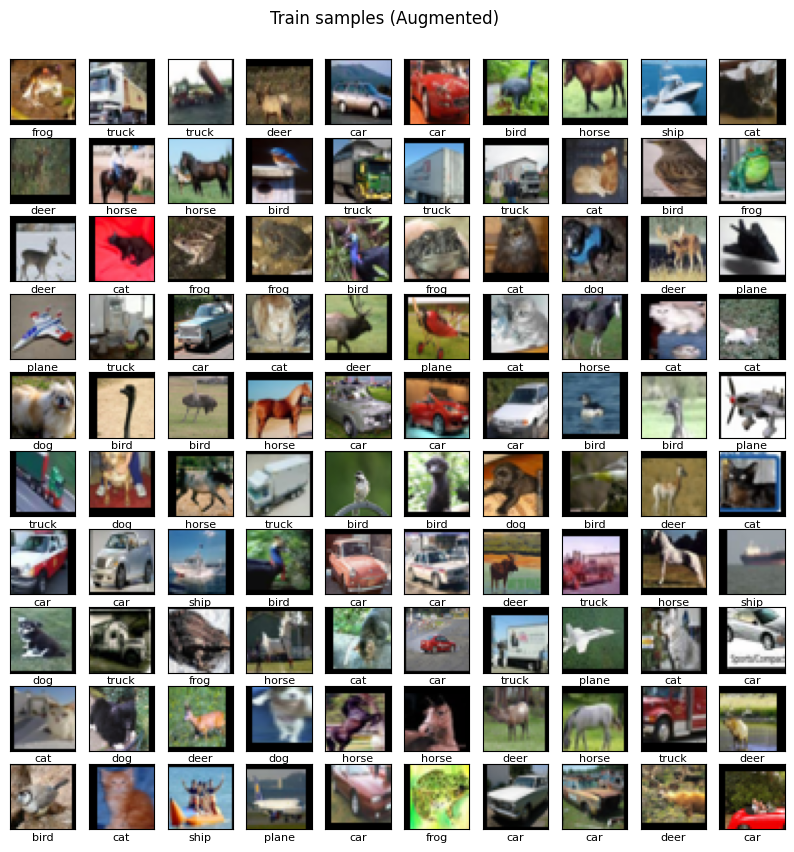

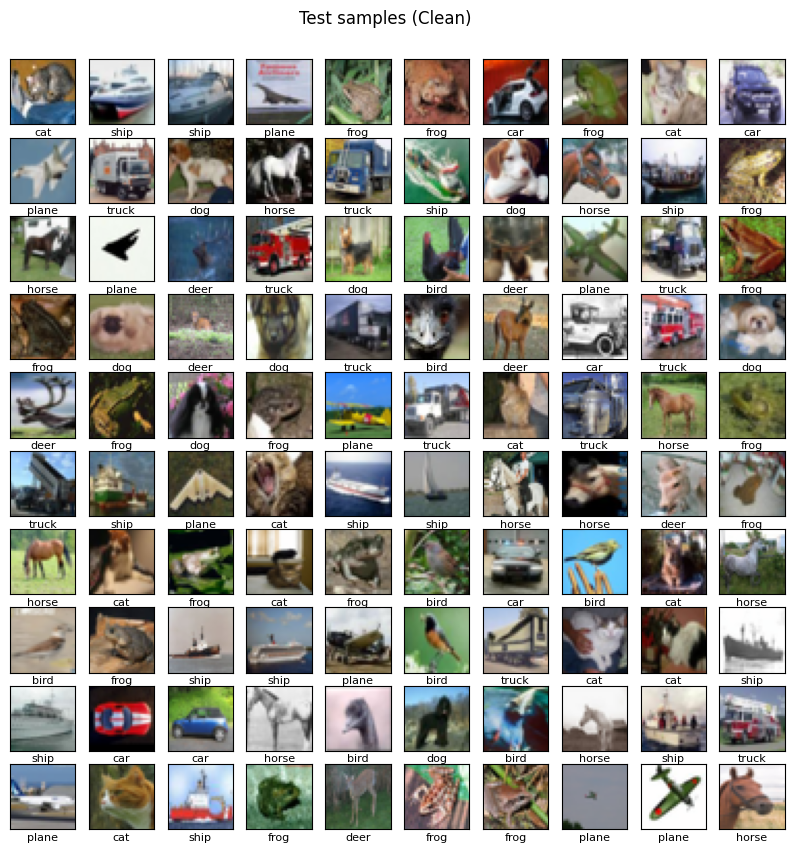

In [4]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dir_name = os.getcwd()
batch_size = 200

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10
    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title, y = 0.93)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])

    for i, ax in enumerate(axes.flat):
        img_tensor, label = images[i]
        img = img_tensor.numpy().transpose(1, 2, 0)
        img = img * NORM_STD + NORM_MEAN
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        class_name = CLASSES[label]
        ax.set_xlabel(f'{class_name}', fontsize=8, labelpad=2)


print('Number of train samples: {}'.format(len(train_set)))
show_images(train_set, 'Train samples (Augmented)')

print('Number of test samples: {}'.format(len(test_set)))
show_images(test_set, 'Test samples (Clean)')

* Инициализация класса CNN

Буду использовать 3 сверточных слоя, с довольно большой глубиной и сужением по измерениям (Задача не слишком трудная, поэтому как будто хватит)
Кроме того, два fc слоя позволит еще сильнее повысить нелинейность.

_Хотел бы еще узнать подробнее про переобучение и как выбирать, какое количество каналов **круче**_


ReLU без параметров и не требует обучения, поэтому не засовывал ее в self, хотя ее можно и через `nn.ReLU` найти



In [5]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)

        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)

        self.fc1 = nn.Linear(in_features=128 * 4 * 4,
                             out_features=256)

        self.fc2 = nn.Linear(in_features=256,
                             out_features=10)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

cnn = CNN()
for name, param in cnn.named_parameters():
    print(f"\nName:  {name}")
    print(f"Shape: {param.shape}")


Name:  conv1.weight
Shape: torch.Size([32, 3, 3, 3])

Name:  conv1.bias
Shape: torch.Size([32])

Name:  conv2.weight
Shape: torch.Size([64, 32, 3, 3])

Name:  conv2.bias
Shape: torch.Size([64])

Name:  conv3.weight
Shape: torch.Size([128, 64, 3, 3])

Name:  conv3.bias
Shape: torch.Size([128])

Name:  fc1.weight
Shape: torch.Size([256, 2048])

Name:  fc1.bias
Shape: torch.Size([256])

Name:  fc2.weight
Shape: torch.Size([10, 256])

Name:  fc2.bias
Shape: torch.Size([10])


* обучение сетки

SGD - вычисление градиента по батчу,
MultiStepLR позволяем менять скорость обучения и замедляться в конце для более точной настройки

In [6]:
NUM_EPOCHS = 35
LEARNING_RATE = 0.1
PATH = './final.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 28, 30, 32, 33],
    gamma=0.3
)

accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
start_time = time.time()


best_acc = 0
for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.requires_grad_().to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy_metric.update(outputs, labels)
    epoch_accuracy = accuracy_metric.compute()
    if epoch_accuracy > best_acc:
        best_acc = epoch_accuracy
        torch.save(cnn.state_dict(), PATH)
    print(f'Epoch[{epoch}]: accuracy = {epoch_accuracy:.4f}')
    accuracy_metric.reset()

end_time = time.time()
total_time = end_time - start_time

print(f"Total training time: {total_time:.2f} seconds")
print(f"Total training time (minutes): {total_time / 60:.2f}")


Epoch[0]: accuracy = 0.3524
Epoch[1]: accuracy = 0.5141
Epoch[2]: accuracy = 0.5993
Epoch[3]: accuracy = 0.6571
Epoch[4]: accuracy = 0.6928
Epoch[5]: accuracy = 0.7180
Epoch[6]: accuracy = 0.7387
Epoch[7]: accuracy = 0.7510
Epoch[8]: accuracy = 0.7636
Epoch[9]: accuracy = 0.7733
Epoch[10]: accuracy = 0.7825
Epoch[11]: accuracy = 0.7947
Epoch[12]: accuracy = 0.8020
Epoch[13]: accuracy = 0.8073
Epoch[14]: accuracy = 0.8116
Epoch[15]: accuracy = 0.8177
Epoch[16]: accuracy = 0.8235
Epoch[17]: accuracy = 0.8278
Epoch[18]: accuracy = 0.8317
Epoch[19]: accuracy = 0.8356
Epoch[20]: accuracy = 0.8400
Epoch[21]: accuracy = 0.8411
Epoch[22]: accuracy = 0.8447
Epoch[23]: accuracy = 0.8505
Epoch[24]: accuracy = 0.8517
Epoch[25]: accuracy = 0.8555
Epoch[26]: accuracy = 0.8579
Epoch[27]: accuracy = 0.8577
Epoch[28]: accuracy = 0.8624
Epoch[29]: accuracy = 0.8616
Epoch[30]: accuracy = 0.8661
Epoch[31]: accuracy = 0.8655
Epoch[32]: accuracy = 0.8672
Epoch[33]: accuracy = 0.8719
Epoch[34]: accuracy = 0.

Accuracy на тестировочном запуске

In [7]:
best_model = CNN()
best_model.load_state_dict(torch.load(PATH))
best_model.to(device)


def calculate_test_accuracy(data_loader, model, device_):
    test_accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device_)
    model.eval()
    batch_time = 0

    with torch.no_grad():
        for _images, _labels in data_loader:
            start = time.time()
            _images = _images.to(device_)
            _labels = _labels.to(device_)
            _outputs = model(_images)
            test_accuracy_metric.update(_outputs, _labels)
            end = time.time()
            batch_time += end - start

    final_accuracy = test_accuracy_metric.compute()
    test_accuracy_metric.reset()
    return final_accuracy.item(), batch_time / len(data_loader.dataset)


test_acc, avg_time = calculate_test_accuracy(test_data_loader, best_model, device)
print('Test accuracy: {:.4f}'.format(test_acc))
print('Average time per image: {:.9f} sec'.format(avg_time))
print('FPS : {:.9f}'.format(1/avg_time))


Test accuracy: 0.8249
Average time per image: 0.000082746 sec
FPS : 12085.182548233
